<a href="https://colab.research.google.com/github/kaisei3506/close_price_prediction/blob/main/close_price_prediction_by_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [38]:
!pip install japanize_matplotlib
import japanize_matplotlib

In [39]:
# 再現性の確保

import os
import random
import numpy as np
import tensorflow as tf

os.environ['PYTHONHASHSEED'] = '42'

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

try:
    tf.config.experimental.enable_op_determinism()
    print("TensorFlow deterministic operations enabled.")
except AttributeError as e:
    print(f"Note: tf.config.experimental.enable_op_determinism() not available in this TF version. Using TF_DETERMINISTIC_OPS='1' might be necessary if supported. Error: {e}")


TensorFlow deterministic operations enabled.


In [40]:
# データクリーニング

# マイドライブにCSVファイルをアップロードし、パスを変更してください
df = pd.read_csv('/content/drive/MyDrive/assignment-main(new)/Trainee/time-series-prediction/stock_price.csv')

def parse_volume(s):
  if 'B' in s:
    return float(s.replace('B', '')) * 1e9
  elif 'M' in s:
    return float(s.replace('M', '')) * 1e6
  else:
    return float(s)

def clean(df):
  df_new = df.copy()
  df_new = df_new[::-1]
  df_new = df_new.rename(columns={'日付け': 'date', '終値': 'close', '始値': 'open', '高値': 'high', '安値': 'low', '出来高': 'volume', '変化率 %': 'return'})
  df_new['date'] = pd.to_datetime(df_new['date'])
  df_new = df_new.set_index('date')
  df_new['volume'] = df_new['volume'].apply(parse_volume)
  df_new['return'] = df_new['return'].str.replace('%', '').astype(float) / 100
  return df_new

cleaned_df = clean(df)
cleaned_df

,close,open,high,low,volume,return
date,,,,,,
1987-02-12,182.4,182.4,182.4,182.4,1.280000e+09,0.1625
1987-02-13,172.5,176.5,176.5,172.5,4.223800e+08,-0.0543
1987-02-16,175.5,166.7,175.5,165.7,3.605100e+08,0.0174
1987-02-17,182.4,176.5,184.3,175.5,8.815100e+08,0.0393
1987-02-18,191.2,186.3,191.2,186.3,7.950900e+08,0.0482
...,...,...,...,...,...,...
2024-07-26,157.9,159.3,159.6,157.9,1.550800e+08,-0.0013
2024-07-29,159.7,158.7,160.2,158.4,1.262800e+08,0.0114
2024-07-30,158.7,158.8,159.2,158.0,1.381400e+08,-0.0063


In [41]:
# 特徴量エンジニアリング

def engineer(df_old):

  df_new = df_old.copy()

  df_new['sin_dayofyear'] = np.sin(2 * np.pi * df_new.index.dayofyear / 365)
  df_new['cos_dayofyear'] = np.cos(2 * np.pi * df_new.index.dayofyear / 365)
  df_new['sin_dayofmonth'] = np.sin(2 * np.pi * df_new.index.day / 30)
  df_new['cos_dayofmonth'] = np.cos(2 * np.pi * df_new.index.day / 30)

  # 移動平均、相対力指数
  sma_list = [5, 10]
  for i in sma_list:
    df_new[f'sma_{i}'] = df_new['close'].rolling(window=i).mean()
    df_new[f'ema_{i}'] = df_new['close'].ewm(span=i, adjust=False).mean()

  # 標準偏差
  for i in sma_list:
    df_new[f'std_{i}'] = df_new['close'].rolling(window=i).std()

  # ADX
  epsilon = 1e-6
  df_new['+DM'] = df_new['high'] - df_new['high'].shift(1)
  df_new['-DM'] = df_new['low'].shift(1) - df_new['low']
  df_new['TR'] = np.maximum.reduce([
    df_new['high'] - df_new['low'],
    abs(df_new['high'] - df_new['close'].shift(1)),
    abs(df_new['low'] - df_new['close'].shift(1))
    ])
  df_new['+DI'] = df_new['+DM'].rolling(window=14).sum() / (df_new['TR'].rolling(window=14).sum() + epsilon) * 100
  df_new['-DI'] = df_new['-DM'].rolling(window=14).sum() / (df_new['TR'].rolling(window=14).sum() + epsilon) * 100
  df_new['DX'] = abs((df_new['+DI'] - df_new['-DI']) / (df_new['+DI'] + df_new['-DI'] + epsilon)) * 100
  df_new['ADX'] = df_new['DX'].rolling(window=14).mean()

  # ストキャスティクス
  df_new['%K'] = (df_new['close'] - df_new['low'].rolling(window=14).min()) / (df_new['high'].rolling(window=14).max() - df_new['low'].rolling(window=14).min()) * 100
  df_new['%D'] = df_new['%K'].rolling(window=3).mean()



  df_new = df_new.drop(['volume', '+DM', '-DM', 'TR', '+DI', '-DI', '%K'], axis=1)

  df_new = df_new.dropna()


  return df_new

engineered_df = engineer(cleaned_df)
engineered_df

,close,open,high,low,return,sin_dayofyear,cos_dayofyear,sin_dayofmonth,cos_dayofmonth,sma_5,ema_5,sma_10,ema_10,std_5,std_10,DX,ADX,%D
date,,,,,,,,,,,,,,,,,,
1987-03-23,260.8,263.7,267.6,260.8,0.0038,0.987349,0.158559,-9.945219e-01,0.104528,267.26,266.156249,274.22,269.115180,8.175145,9.394656,2.450001e+02,5.781730e+08,12.637943
1987-03-24,256.9,264.7,264.7,256.9,-0.0150,0.989932,0.141540,-9.510565e-01,0.309017,263.14,263.070832,272.26,266.894238,6.799485,10.804855,1.420000e+03,5.781730e+08,10.700425
1987-03-25,254.9,255.9,256.9,252.9,-0.0078,0.992222,0.124479,-8.660254e-01,0.500000,259.22,260.347222,269.71,264.713468,3.425931,11.646597,7.321840e+02,5.781729e+08,8.295781
1987-03-26,262.7,258.8,264.7,255.9,0.0306,0.994218,0.107381,-7.431448e-01,0.669131,259.02,261.131481,267.55,264.347383,3.114001,10.595623,1.858621e+03,5.781721e+08,12.402657
1987-03-27,274.5,267.6,284.3,263.7,0.0449,0.995919,0.090252,-5.877853e-01,0.809017,261.96,265.587654,266.57,266.193313,7.658198,9.240857,1.609375e+02,5.781706e+08,30.492167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-26,157.9,159.3,159.6,157.9,-0.0013,-0.425000,-0.905193,-7.431448e-01,0.669131,159.02,158.602261,159.05,158.512757,1.221475,1.202082,2.100004e+03,8.685501e+08,59.848485
2024-07-29,159.7,158.7,160.2,158.4,0.0114,-0.471160,-0.882048,-2.079117e-01,0.978148,158.98,158.968174,159.15,158.728619,1.188276,1.211289,1.733334e+03,4.649221e+08,63.839616
2024-07-30,158.7,158.8,159.2,158.0,-0.0063,-0.486273,-0.873807,-1.133108e-15,1.000000,158.58,158.878783,159.30,158.723416,0.701427,1.020893,2.913044e+02,4.649221e+08,60.809313


close	open	high	low	return	sin_dayofyear	cos_dayofyear	sin_dayofmonth	cos_dayofmonth	sma_5	ema_5	sma_10	ema_10	std_5	std_10	DX	ADX	%D

In [42]:
# データの分割

train_valid = engineered_df['2019-01-01':'2023-12-31']

train = train_valid[:'2022-11-30']
enbargo_train_valid = train_valid['2022-12-01':'2022-12-31']
valid = train_valid['2023-01-01':'2023-05-15']
enbargo_valid_test = engineered_df['2023-05-16':'2023-12-31']
test = engineered_df['2024-01-01':'2024-07-31']

In [43]:
sequence_length = 22 # 入力シーケンス長
predict_length = 1 # 出力長

# LSTM用のデータセットを作成

def create_dataset(data, sequence_length, predict_length):
  X, y = [], []
  for i in range(len(data) - sequence_length - predict_length + 1):
    X.append(data[i:i+sequence_length, :])
    y.append(data[i+sequence_length:i+sequence_length+predict_length, 0])
  return np.array(X), np.array(y)

X_train, y_train = create_dataset(train.values, sequence_length, predict_length)
X_valid, y_valid = create_dataset(valid.values, sequence_length, predict_length)
X_test, y_test = create_dataset(test.values, sequence_length, predict_length)

# LSTM用の入力形に変換（サンプル数、入力シーケンス長、特徴量数）

y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], 1)
y_valid = y_valid.reshape(y_valid.shape[0], y_valid.shape[1], 1)

In [44]:
from sklearn.preprocessing import StandardScaler

# 特徴量（X）のスケーリング
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_valid_scaled = scaler_X.transform(X_valid.reshape(-1, X_valid.shape[-1])).reshape(X_valid.shape)
X_test_scaled = scaler_X.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# 目的変数（y）のスケーリング
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, y_train.shape[-1])).reshape(y_train.shape)
y_valid_scaled = scaler_y.transform(y_valid.reshape(-1, y_valid.shape[-1])).reshape(y_valid.shape)
y_test_scaled = scaler_y.transform(y_test.reshape(-1, y_test.shape[-1])).reshape(y_test.shape)

In [45]:
import tensorflow as tf
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras import optimizers as optim
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Layer
from tensorflow.keras.models import Model
from tensorflow.keras import layers, models, regularizers, optimizers

In [46]:
# LSTM

lstm_model = Sequential()

lstm_model.add(LSTM(units=128,
                    return_sequences=True,
                    input_shape=(X_train.shape[1], X_train.shape[2]),
                    kernel_regularizer=regularizers.l2(0.001),
                    recurrent_regularizer=regularizers.l2(0.001)
                    )
)

lstm_model.add(Dropout(0.2))

lstm_model.add(LSTM(units=64,
                    return_sequences=True,
                    kernel_regularizer=regularizers.l2(0.001),
                    recurrent_regularizer=regularizers.l2(0.001)
                    )
)

lstm_model.add(Dropout(0.2))

lstm_model.add(LSTM(units=32,
                    return_sequences=False,
                    kernel_regularizer=regularizers.l2(0.001),
                    recurrent_regularizer=regularizers.l2(0.001)
                    )
)

lstm_model.add(Dropout(0.2))

lstm_model.add(Dense(predict_length,
                     kernel_regularizer=regularizers.l2(0.001)
                     )
)


optimizer = optim.Adam(learning_rate=0.001)
lstm_model.compile(optimizer=optimizer, loss='mse')
lstm_model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 22, 128)        │        75,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 22, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 22, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 22, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 137,121 (535.63 KB)

 Trainable params: 137,121 (535.63 KB)

 Non-trainable params: 0 (0.00 B)

In [47]:
# Transformer


# ポジショナルエンコーディング層
class PositionalEncoding(layers.Layer):
  def __init__(self, sequence_len, d_model):
      super(PositionalEncoding, self).__init__()
      self.pos_encoding = self.positional_encoding(sequence_len, d_model)

  def get_config(self):
      return {"sequence_len": self.pos_encoding.shape[1], "d_model": self.pos_encoding.shape[2]}

  def get_angles(self, pos, i, d_model):
      angles = pos / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
      return angles

  def positional_encoding(self, position, d_model):
      angle_rads = self.get_angles(
          pos=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
          i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
          d_model=d_model)

      sines = tf.math.sin(angle_rads[:, 0::2])
      cosines = tf.math.cos(angle_rads[:, 1::2])
      pos_encoding = tf.concat([sines, cosines], axis=-1)
      return pos_encoding[tf.newaxis, ...]

  def call(self, inputs):
      return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

# エンコーダ
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.2):
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(num_heads=num_heads, key_dim=head_size,
                                   kernel_regularizer=regularizers.l2(0.001))(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Dense(ff_dim, activation="relu",
                     kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(inputs.shape[-1],
                     kernel_regularizer=regularizers.l2(0.001))(x)
    return x + res

# モデル構築
sequence_length = X_train.shape[1]
num_features = X_train.shape[2]

inputs = layers.Input(shape=(sequence_length, num_features))

# 1. ポジショナルエンコーディング
x = PositionalEncoding(sequence_length, num_features)(inputs)

# 2. エンコーダ
x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=128, dropout=0.2)
x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=128, dropout=0.2)

# 3. グローバル平均プーリング
x = layers.GlobalAveragePooling1D()(x)

# 4. 出力層
outputs = layers.Dense(predict_length,
                       kernel_regularizer=regularizers.l2(0.001))(x)

# モデル定義
transformer_model = models.Model(inputs, outputs)
transformer_model.compile(
    loss="mse",
    optimizer=optimizers.Adam(learning_rate=0.001),
)

transformer_model.summary()


Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 22, 18)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encoding │ (None, 22, 18)    │          0 │ input_layer_3[0]… │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 22, 18)    │         36 │ positional_encod… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 22, 18)    │     19,218 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 22, 18)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 22, 18)    │          0 │ dropout_10[0][0], │
│                     │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 22, 18)    │         36 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 22, 128)   │      2,432 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 22, 128)   │          0 │ dense_3[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 22, 18)    │      2,322 │ dropout_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 22, 18)    │          0 │ dense_4[0][0],    │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 22, 18)    │         36 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 22, 18)    │     19,218 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 22, 18)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 22, 18)    │          0 │ dropout_13[0][0], │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 22, 18)    │         36 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 22, 128)   │      2,432 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 22, 128)   │          0 │ dense_5[0][0]   

 Total params: 48,107 (187.92 KB)

 Trainable params: 48,107 (187.92 KB)

 Non-trainable params: 0 (0.00 B)

In [48]:
from tensorflow.keras.callbacks import EarlyStopping

# モデルを学習させる関数

def train_model_with_early_stopping(model,
                                    X_train, y_train,
                                    X_valid, y_valid,
                                    epochs=1000,
                                    batch_size=128,
                                    patience=20):

  # 早期終了
  es = EarlyStopping(monitor='val_loss',
                      mode='min',
                      verbose=1,
                      patience=patience,
                      restore_best_weights=True)

  # 学習
  history = model.fit(
      X_train, y_train,
      epochs=epochs,
      batch_size=batch_size,
      validation_data=(X_valid, y_valid),
      shuffle=False,
      callbacks=[es]
  )

  # 検証スコアが最も良いエポック、訓練・検証データの損失を保存
  best_epoch = np.argmin(history.history['val_loss']) + 1
  best_train_loss = history.history['loss'][best_epoch - 1]
  best_val_loss = history.history['val_loss'][best_epoch - 1]

  print(f"\n最良エポック: {best_epoch}")
  print(f"訓練損失: {best_train_loss}")
  print(f"検証損失: {best_val_loss}")

  # 学習曲線の描画
  plt.figure(figsize=(10, 5))
  plt.plot(history.history['loss'], label='Train Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.axvline(x=best_epoch - 1, color='r', linestyle='--', label='Best Epoch')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.title('Training Curve')
  plt.grid()
  plt.tight_layout()
  plt.show()

  return model


Epoch 1/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 753ms/step - loss: 0.7411 - val_loss: 0.6562
Epoch 2/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 234ms/step - loss: 0.6703 - val_loss: 0.5260
Epoch 3/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step - loss: 0.6103 - val_loss: 0.5227
Epoch 4/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - loss: 0.5507 - val_loss: 0.4762
Epoch 5/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - loss: 0.4920 - val_loss: 0.7861
Epoch 6/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - loss: 0.4635 - val_loss: 0.5461
Epoch 7/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - loss: 0.4484 - val_loss: 0.4582
Epoch 8/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - loss: 0.4347 - val_loss: 0.4520
Epoch 9/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step - loss: 0.4165 - val_loss: 0.4719
Epoch 10/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 233ms/step - loss: 0.4034 - val_loss: 0.4543
Epoch 11/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - loss: 0.3868 - val_loss: 0.4286
Epoch 12/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/ste

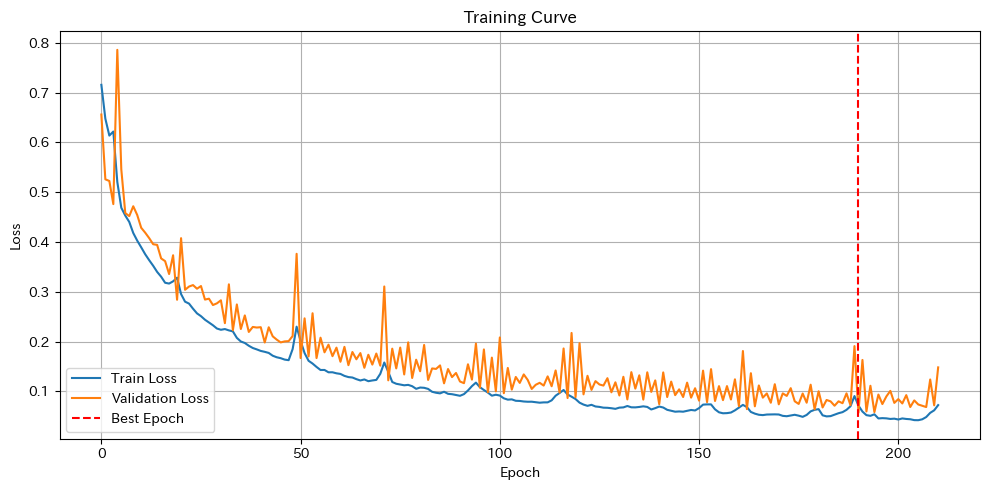

In [49]:
# LSTMモデルの学習
lstm_model = train_model_with_early_stopping(lstm_model,
                                             X_train_scaled, y_train_scaled,
                                             X_valid_scaled, y_valid_scaled
)

Epoch 1/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 238ms/step - loss: 0.9242 - val_loss: 1.5413
Epoch 2/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - loss: 0.5658 - val_loss: 0.5945
Epoch 3/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - loss: 0.8036 - val_loss: 1.7914
Epoch 4/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - loss: 0.8323 - val_loss: 1.4477
Epoch 5/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - loss: 0.6721 - val_loss: 0.7916
Epoch 6/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step - loss: 0.2994 - val_loss: 0.2802
Epoch 7/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 245ms/step - loss: 0.3120 - val_loss: 0.2471
Epoch 8/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 215ms/step - loss: 0.2642 - val_loss: 0.3619
Epoch 9/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 244ms/step - loss: 0.2539 - val_loss: 0.3698
Epoch 10/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - loss: 0.2517 - val_loss: 0.2861
Epoch 11/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step - loss: 0.2474 - val_loss: 0.2598
Epoch 12/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/ste

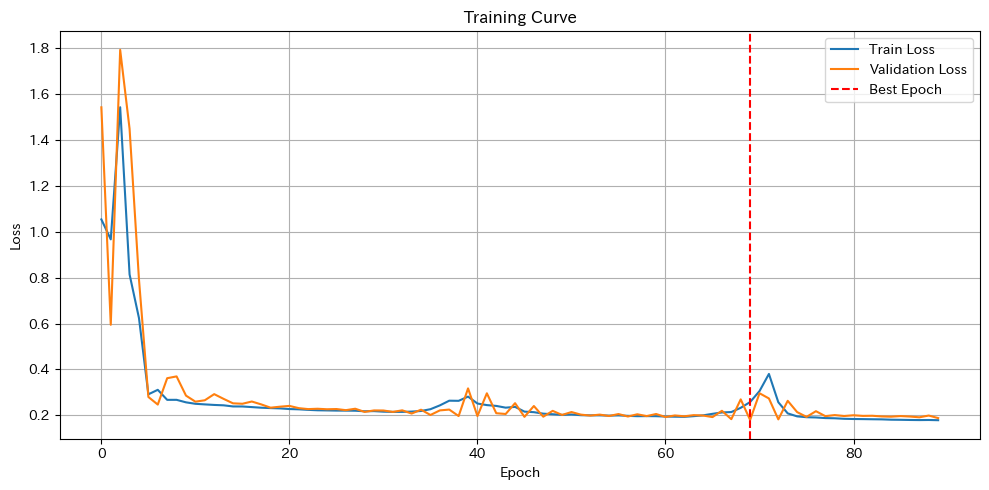

In [50]:
# Transformerモデルの学習
transformer_model = train_model_with_early_stopping(transformer_model,
                                                     X_train_scaled, y_train_scaled,
                                                     X_valid_scaled, y_valid_scaled
)

In [51]:
from sklearn.metrics import mean_squared_error

# テストデータに対する汎化性能を評価

def evaluate(model, X_test_scaled, y_test_scaled, y_test, scaler_y, test_df, sequence_length):
    y_test_pred_scaled = model.predict(X_test_scaled)
    y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)
    y_test_pred = y_test_pred.flatten()
    y_test = y_test.flatten()

    scaled_test_mse = mean_squared_error(y_test_scaled, y_test_pred_scaled)
    inversed_test_mse = mean_squared_error(y_test, y_test_pred)
    inversed_test_rmse = np.sqrt(inversed_test_mse)

    print(f"Scaled Test MSE: {scaled_test_mse}")
    print(f"Inversed Test MSE: {inversed_test_mse}")
    print(f"Inversed Test RMSE: {inversed_test_rmse}")

    plt.figure(figsize=(16, 8))
    plt.plot(test_df.index, test_df['close'].values, label='実測値')
    plt.plot(test_df[sequence_length:].index, y_test_pred, label='予測値')
    plt.title('終値の予測', fontsize=25)
    plt.xlabel('日付', fontsize=20)
    plt.ylabel('終値', fontsize=20)
    plt.legend(fontsize=20)
    plt.grid()
    plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step
Scaled Test MSE: 0.37400223070894234
Inversed Test MSE: 162.20390745473668
Inversed Test RMSE: 12.735929783676443


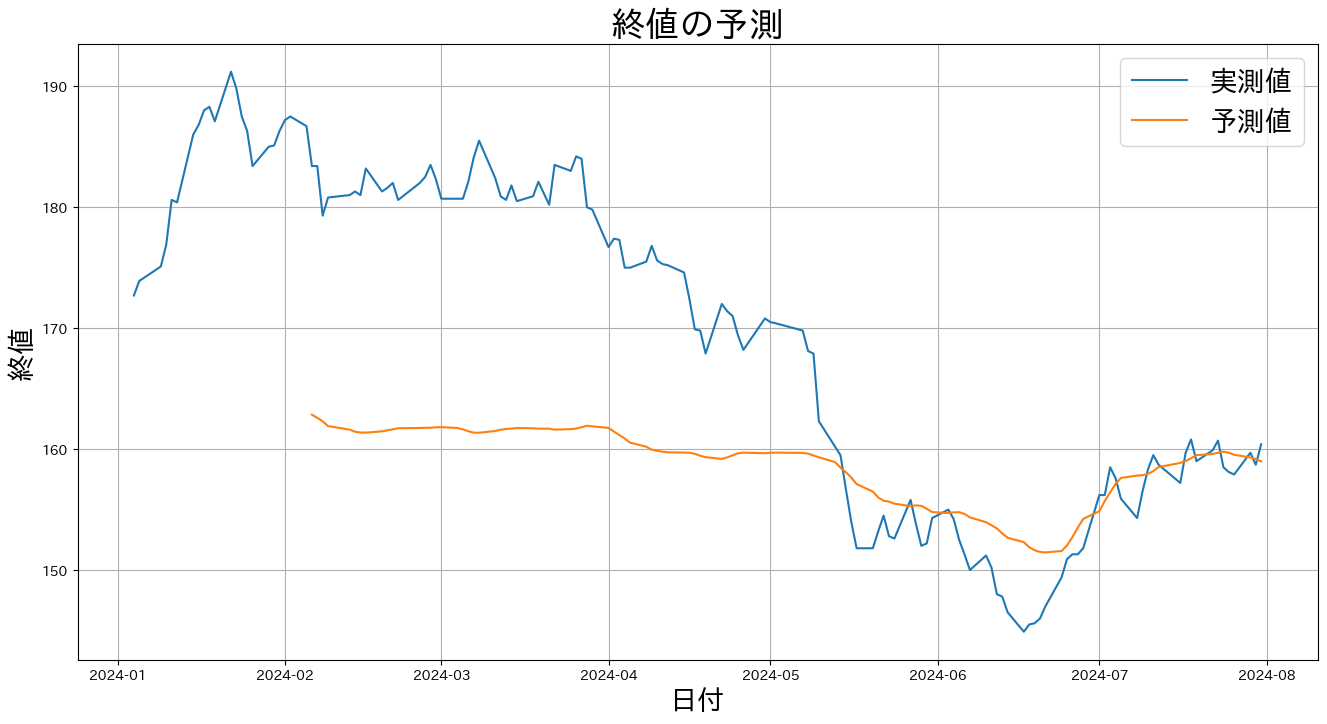

In [52]:
# LSTMモデルの評価
evaluate(lstm_model, X_test_scaled, y_test_scaled, y_test, scaler_y, test, sequence_length)

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step
Scaled Test MSE: 0.061490919121148346
Inversed Test MSE: 26.66846557411473
Inversed Test RMSE: 5.164151970470537


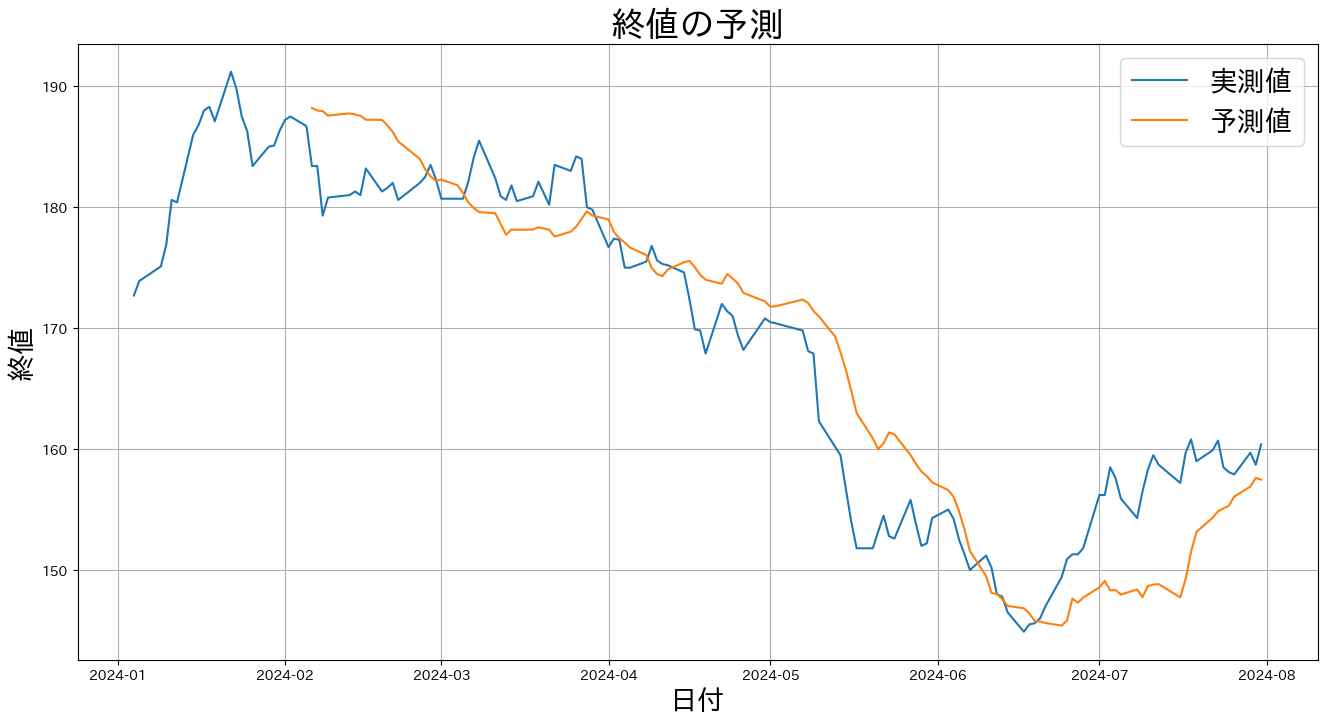

In [53]:
# Transformerモデルの評価
evaluate(transformer_model, X_test_scaled, y_test_scaled, y_test, scaler_y, test, sequence_length)